# GitHub API REST v3 -> Commitの特徴
ここではコミットのばらつきを確認します。

## リポジトリの確認と指定方法
例えば以下の条件で調べると, microsoft/vscodeと出てきます。
- microsoft -> owner
- vscode -> repo

https://github.com/search?q=vscode 

In [1]:
# input values
owner = "microsoft"
repo = "vscode"

print("[owner]{0} [repo]{1}について出力します。".format(owner, repo))

import datetime
print("実行日:{0}".format(datetime.datetime.now()))

[owner]microsoft [repo]vscodeについて出力します。
実行日:2020-09-05 06:56:18.527507


## ライブラリのインポート

In [2]:
# Libraries
import requests
import json
import pprint
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime

## original Libraries
import config_manager as cnf
import github_api.github_api_manager as gapi

## ユーザー情報の取得
- ユーザー名とパスワードを取得します。
- ユーザー情報は、config\setting.cnfに設定します。

In [3]:
# load config file
cnf_data = cnf.confg_manager()
cnf_data.load()
username, userpassword = cnf_data.get_userparam()

# create github api object
gapi_ctrl = gapi.github_api_manager(username, userpassword)

## GitHub APIを叩いてCommit数を取得

このページに表示される総コミット数と微妙に数値が異なる
https://github.com/microsoft/vscode

どうやら
https://docs.github.com/en/rest/reference/repos#statistics
によるとマージコミットと空のコミットは除外されるらしい。

In [4]:

# create contribute stats api
github_api = "/repos/{owner}/{repo}/stats/contributors" \
    .replace("{owner}", owner).replace("{repo}", repo)

ret_json = gapi_ctrl.get_json(github_api,True)

# create Empty dataframe
df = pd.DataFrame(index=[], columns=ret_json[0].keys())
df2 = pd.DataFrame(index=[], columns=ret_json[0]['weeks'][0].keys())

# apend data
for k in ret_json:
    df = df.append(pd.DataFrame.from_dict(k, orient='index').T)

    # apend data
    for k2 in k['weeks']:
        df_tmp = pd.DataFrame.from_dict(k2, orient='index').T
        df_tmp['login'] = k['author']['login']
        df2 = df2.append(df_tmp)

print("総コミット数 : {0}".format(df.total.astype(int).sum()))

GET https://api.github.com/repos/microsoft/vscode/stats/contributors
総コミット数 : 61644


# ざっくりの情報確認

In [5]:
# cast
df_cal = df2.assign(date=lambda x: pd.to_datetime(x.w.astype(int), unit='s')) \
    .loc[:, ['date', 'c']] \
    .groupby('date').sum().reset_index() \
    .rename(columns={'c':'commit_per_week'}) \
    .sort_values('date')

df_cal.commit_per_week = df_cal.commit_per_week.astype(int)

print("--- 情報 ---")
df_cal.describe().T

--- 情報 ---


,count,mean,std,min,25%,50%,75%,max
commit_per_week,252.0,244.619048,75.387483,13.0,203.0,251.5,290.0,421.0


# 週ごとのcommit数の推移

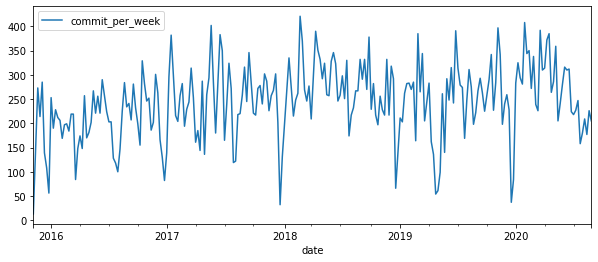

In [6]:
# show line chart
df_cal.groupby('date').sum().plot(figsize=(10,4))

# コミット数ばらつき

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FFC5A067C0>]],
      dtype=object)

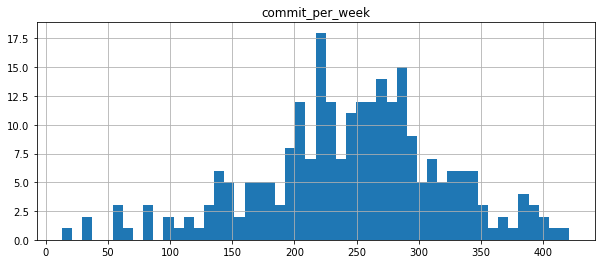

In [7]:
# show histogram
df_cal.hist(bins=50, figsize=(10,4))

In [8]:
df2.loc[:,['login', 'c']].groupby('login').sum().describe().T

,count,mean,std,min,25%,50%,75%,max
c,99.0,622.666667,1557.995527,10.0,14.0,24.0,235.5,8233.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FFC5B28C10>]],
      dtype=object)

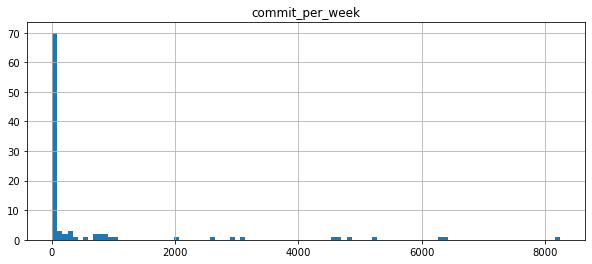

In [9]:
df2.loc[:,['login', 'c']].groupby('login').sum() \
    .rename(columns={'c':'commit_per_week'}).hist(figsize=(10,4), bins=100)

In [10]:
percentile = 0.8

df_tmp = df2.loc[:,['login', 'c']].groupby('login').sum() \
    .reset_index().rename(columns={'c':'commit'}) \
    .sort_values('commit', ascending=False)

df_tmp = df2.loc[:,['login', 'c']].groupby('login').sum() \
    .reset_index().rename(columns={'c':'commit'}) \
    .assign(div = lambda d:d['commit'] > int(df_tmp.quantile(percentile)))\
    .sort_values('commit', ascending=False) \
    .groupby('div').sum().reset_index() \
    .assign(ratio=lambda d:(d['commit'] / df_tmp['commit'].sum())*100)

df_tmp.loc[df_tmp['div'] == True, ['div']] = 'upper {:.1f}%'.format((1 - percentile) * 100)
df_tmp.loc[df_tmp['div'] == False, ['div']] = 'lower {:.1f}%'.format(percentile * 100)

df_tmp

,div,commit,ratio
0,lower 80.0%,3768,6.112517
1,upper 20.0%,57876,93.887483


# コミット数の少ない日ランキング 10

In [11]:
df_cal.sort_values('commit_per_week').head(10).reset_index()

,index,date,commit_per_week
0,0,2015-11-08,13
1,111,2017-12-24,32
2,215,2019-12-22,37
3,181,2019-04-28,54
4,7,2015-12-27,56
5,182,2019-05-05,61
6,163,2018-12-23,66
7,59,2016-12-25,82
8,19,2016-03-20,84
9,216,2019-12-29,84


# コミット数の多い日ランキング 10

In [12]:
df_cal.sort_values('commit_per_week', ascending=False).head(10).reset_index()

,index,date,commit_per_week
0,120,2018-02-25,421
1,221,2020-02-02,408
2,80,2017-05-21,402
3,209,2019-11-10,397
4,228,2020-03-22,392
5,190,2019-06-30,391
6,127,2018-04-15,390
7,173,2019-03-03,385
8,232,2020-04-19,385
9,84,2017-06-18,383
